## Trace ratio optimization

We want to solve the following Trace Ratio Optimization (TRO) problem

$P: \text{max}_X\; \frac{\mathbb{E}[||X^T\mathbf{y}(t)||^2]}{\mathbb{E}[||X^T\mathbf{v}(t)||^2]}$
$\text{s.t. } X^TX=I,$

in a distributed setting using the distributed signal fusion optimization (DSFO) framework.

In [1]:
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
sys.path.append('../')
import tro_functions as tro
from dsfo_toolbox import dsfo

rng = np.random.default_rng()

The network on which the TRO problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.

In [2]:
# Number of nodes.
nbnodes = 10
# Number of channels per node.
nbsensors_vec = 5 * np.ones(nbnodes)
nbsensors_vec = nbsensors_vec.astype(int)
# Number of channels in total.
nbsensors = np.sum(nbsensors_vec)
# Create adjacency matrix (hollow matrix) of a random graph.
graph_adj = rng.integers(0, 1, size=(nbnodes, nbnodes), endpoint=True)
graph_adj = np.triu(graph_adj, 1) + np.tril(graph_adj.T, -1)

The adjacency matrix of the network is:

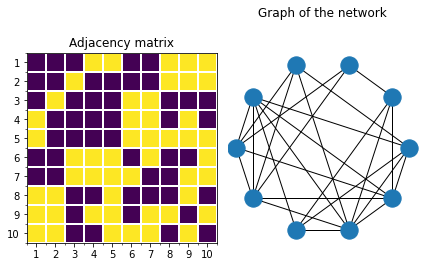

In [3]:
%matplotlib inline

fig, ax = plt.subplots(1, 2)
ax[0].imshow(graph_adj)
ax[0].set_xticks(np.arange(0, 10, 1))
ax[0].set_yticks(np.arange(0, 10, 1))
ax[0].set_xticklabels(np.arange(1, 11, 1))
ax[0].set_yticklabels(np.arange(1, 11, 1))
ax[0].set_xticks(np.arange(-.5, 10, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, 10, 1), minor=True)
ax[0].grid(which='minor', color='w', linestyle='-', linewidth=2)
ax[0].set_title('Adjacency matrix')

graph = nx.from_numpy_array(graph_adj)
nx.draw_circular(graph)
ax[1].set_title('Graph of the network')
ax[1].axis('equal')

plt.tight_layout()
plt.show()


We now create the multi-channel signals $\mathbf{y}$ and $\mathbf{v}$
measured at the nodes, using the following mixture model:
$\mathbf{v}(t)=B\cdot\mathbf{s}(t)+\mathbf{n}(t),\\$
$\mathbf{y}(t)=A\cdot\mathbf{d}(t)+\mathbf{v}(t).$

Each node measures blocks of 10000 samples to estimate the correlation matrices.

In [4]:
def create_data(nbsensors, nbsamples):
    rng = np.random.default_rng()

    nbsources = 5
    latent_dim = 10

    d = rng.standard_normal(size=(nbsamples, nbsources))
    s = rng.standard_normal(size=(nbsamples, latent_dim - nbsources))
    A = rng.uniform(low=-0.5, high=0.5, size=(nbsources, nbsensors))
    B = rng.uniform(low=-0.5, high=0.5, size=(latent_dim - nbsources, nbsensors))
    noise = rng.standard_normal(size=(nbsamples, nbsensors))

    V = s @ B + noise
    Y = d @ A + V

    Y = Y.T
    V = V.T

    return Y, V

# Number of samples of the signals.
nbsamples = 10000

Y, V = tro.create_data(nbsensors, nbsamples)

When solving the TRO problem in the DSFO setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is `tro_solver` which solves:

$\text{max}_X\; \frac{\mathbb{E}[||X^T\mathbf{y}_1(t)||^2]}{\mathbb{E}[||X^T\mathbf{y}_2(t)||^2]}$
$\text{s.t. } X^T\Gamma_1X=I.$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$,
$\mathbf{y}_2=\mathbf{v}$ and $\Gamma_1=I$.

The data of the problem are stored in the dictionary `data` (see documentation for
more information).

In [5]:
Y_list = [Y, V]
Gamma_list = [np.identity(nbsensors)]
B_list = []
Glob_Const_list = []

data = {'Y_list': Y_list, 'B_list': B_list,
        'Gamma_list': Gamma_list, 'Glob_Const_list': Glob_Const_list}


The parameters of the problem are stored in the dictionary `prob_params` (see documentation for
more information), where we choose the number of filters $Q$ (i.e., the number of columns of
$X$) to be equal to 5:

In [6]:
# Number of filters of X.
Q = 5

prob_params = {'nbnodes': nbnodes, 'nbsensors_vec': nbsensors_vec,
                   'nbsensors': nbsensors, 'Q': Q, 'nbsamples': nbsamples}

The optimal filter $X^*$ is estimated using the centralized solver `tro_solver` taking
as input the data and problem parameters previously defined:

In [7]:
X_star = tro.tro_solver(prob_params, data)
f_star = tro.tro_eval(X_star, data) # f(X_star)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DSFO algorithm to be equal to 200.

In [8]:
prob_params['graph_adj'] = graph_adj

update_path = rng.permutation(range(nbnodes))
prob_params['update_path'] = update_path

nbiter = 200
conv = {'nbiter': nbiter}

We also provide $X^*$ to compare the estimation we get from the DSFO to the optimal
value.

In [9]:
prob_params['X_star'] = X_star
prob_params['compare_opt'] = True

Finally, the TRO problem is solved in a distributed setting using the DSFO framework:

In [10]:
X_est, norm_diff, norm_err, f_seq = dsfo(prob_params, data, tro.tro_solver,
                                             conv, tro.tro_select_sol, tro.tro_eval)

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

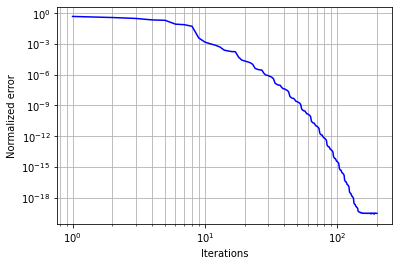

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()